<!--NAVIGATION-->
< [7_Risk_Mapping Python_GDA](7_Risk_Mapping Python_GDAL.ipynb) | [Contents](Index.ipynb)  >

<img align="left" style="width: 350px;" src="figures/logo.png"/>
----------------------------------------------------------------------------------------------------------------------
# Bologna Training Course 23 – 27 January 2017

# Hydrological and Flood Risk Geo-processing with Open Source (Python/GDAL) 
<img  align="left" style="width: 300px;" src="figures/logo2011.jpg"/>

----------------------------------------------------------------------------------------------------------------------
## Stefano Bagli and Paolo Mazzoli - [GECOsistema srl ](www.gecosistema.com)
----------------------------------------------------------------------------------------------------------------------

In [20]:
import gdal,gdalconst
import numpy
import os, glob
import sys
import matplotlib.pyplot as plt
from osgeo import ogr, osr
import csv
#-------------------------------------------------------------------------------
#   GDAL2Numpy
#-------------------------------------------------------------------------------
def GDAL2Numpy(pathname):
    dataset = gdal.Open(pathname,gdalconst.GA_ReadOnly) # open the dataset in read mode
    band = dataset.GetRasterBand(1) # get the first band (Remember that band indices start at 1 instead of 0 )
    cols = dataset.RasterXSize # read number of colums
    rows = dataset.RasterYSize # read number of rows
    geotransform = dataset.GetGeoTransform() # read the geotransform (origin coordinates and pixel sizes, along with rotation values)
    projection = dataset.GetProjection() # read the proj info
    wdata = band.ReadAsArray(0, 0, cols, rows).astype("float32") #read all pixels as array
    nodata =band.GetNoDataValue()
    return (wdata,geotransform,projection,nodata) 
#-------------------------------------------------------------------------------
#   Numpy2GTiff
#-------------------------------------------------------------------------------
def Numpy2GTiff(arr ,geotransform,projection,filename):
    if isinstance(arr,numpy.ndarray):
        rows,cols = arr.shape
        if rows>0 and cols>0:
            dtype = str(arr.dtype)
            if   dtype in ["uint8"]:
                fmt = gdal.GDT_Byte
            elif dtype in ["uint16"]:
                fmt = gdal.GDT_UInt16
            elif dtype in ["uint32"]:
                fmt = gdal.GDT_UInt32
            elif dtype in ["float32"]:
                fmt = gdal.GDT_Float32
            elif dtype in ["float64"]:
                fmt = gdal.GDT_Float64
            else:
                fmt = gdal.GDT_Float64

            driver = gdal.GetDriverByName("GTiff")
            dataset = driver.Create( filename, cols, rows, 1, fmt )
            if (geotransform!=None):
                dataset.SetGeoTransform( geotransform )
            if (projection!=None):
                dataset.SetProjection(projection)
            dataset.GetRasterBand(1).WriteArray( arr )
            dataset = None
            return filename
    return None

# 7- From Flood Hazard to Risk Mapping

The following example shows how to map flood risk from hazard maps (flooded area derived from hydrodynamic models -  LISFLOOD ) through the use of Damage Curves.


## 7.1 Damage Curve

Damage Curve Definition  - relatioship between Water Depth and Damages (Economical, Social, Environmental)
<img style="width: 700px;" src="figures/damage_1.png">

Flood damage functions measure the susceptibility of assets (economic, life or environmental losses) to certain inundation characteristics, in this case specifically inundation depth

### 7.1.1 Social (Life Losses) Damage Function Jonkman
Jonkman Damage function between the water depth and mortality are deived from data from the 1953 flood, in which a storm surge on the North Sea inundated a large part of the South West of the Netherlands and cause 1800 deaths.

<#img src="figures/damage_jon.PNG">

<img src="figures/losslife.PNG">


Boyd et al. (2005) derived a mortality function based on observations from seven flood events, including hurricanes Betsy (1965) and Camille (1969) in the United States.

$$F_{{\text{D}}} = \frac{{0.34}} {{(1 + \exp (20.37 - 6.18h))}}$$

<img src="figures/life1.gif">


In [32]:
import IPython
url = 'http://link.springer.com/article/10.1007/s11069-008-9227-5'
iframe = '<iframe src=' + url + ' width=900 height=500></iframe>'
IPython.display.HTML(iframe)


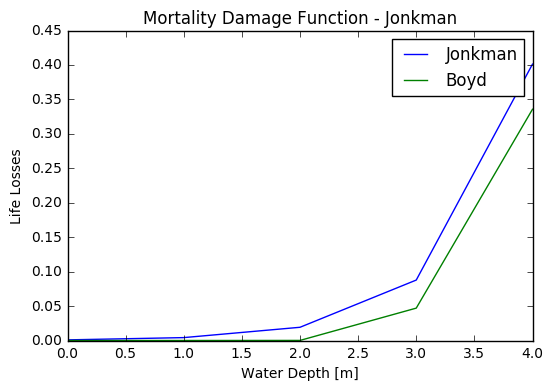

In [31]:
%matplotlib inline
import math

from matplotlib import pyplot as plt
x =numpy.arange(5)
y=0.000918*numpy.exp(1.52*x)
y1=0.34/(1+numpy.exp(20.37-6.18*x))

#y=(-0.21+3.57*numpy.log10(x))/10.0
plt.xlabel('Water Depth [m]') # label
plt.ylabel('Life Losses')
plt.title('Mortality Damage Function - Jonkman')
plt.plot(x, y, label='Jonkman')
plt.plot(x, y1, label='Boyd')
plt.legend()


<img src="figures/nod.PNG">

In [22]:
#def Social_damage_func(workdir,waterdepthfilename,popfilename):
def lifelosses(workdir,waterdepthfilename,Expopfilename):    
    (WDgrid,geotransform,projection,nodata)=GDAL2Numpy(workdir+waterdepthfilename) #read water depth filename    
    #LOL_map=0.0536*WDgrid+0.184 #Linerized Jonkman damage funtion - fraction of life losses    
    #LOL_map=0.0012*numpy.power(WDgrid,3)+0.0257*numpy.power(WDgrid,2)+0.00113*WDgrid
    #LOL_map=(-0.21+3.57*numpy.log(WDgrid))/10.0
    LOL_map=(0.000918*numpy.exp(1.52*WDgrid)) # compute the map of life losses fraction 
    LOL_map=numpy.where(LOL_map>0, LOL_map,0) # force negative values to 0
    LOL_map=numpy.where(LOL_map>1, 1,LOL_map) # force >1 values to 1
    Numpy2GTiff(LOL_map ,geotransform,projection,workdir+'output/'+'LOL_'+waterdepthfilename) # save LifeofLosses map
    (EXPOgrid,geotransform,projection,nodata)=GDAL2Numpy(workdir+Expopfilename) # read population array
    #print LOL_map
    EXPOgrid=numpy.where(EXPOgrid>0, EXPOgrid,0) # force negative values to 0
    # population is ab/km2 - raster size is 100 m - compute the factor in order to evaluate 
    # the number of people living in each pixel
    pixelsize=100.0 # 100 m
    unit=1000.0  # km
    factor=(unit*unit)/(pixelsize*pixelsize)
    
    EXPOgrid=EXPOgrid/factor # number of people living in a 100 m pixel
    
    NumberOfDeathMap=LOL_map*(EXPOgrid)
    NumberOfDeathMap=numpy.where(NumberOfDeathMap>=1, NumberOfDeathMap,0)
    #print NunberOfDeathMap
    print "Total Number of Deaths="+str(numpy.sum(NumberOfDeathMap))
    Numpy2GTiff(NumberOfDeathMap ,geotransform,projection,workdir+'output/'+'NOD_'+waterdepthfilename)
    return 'NOD_'+waterdepthfilename
    

workdir='data/Chap_7/'
waterdepthfilename='floodMapEU_rp500y_Turim.tif'
Expopfilename='popu01clcv5_Turim.tif'
lifelosses(workdir,waterdepthfilename,Expopfilename)

Total Number of Deaths=7186.1


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in multiply


'NOD_floodMapEU_rp500y_Turim.tif'

### 7.1.2 Economical Damage Function

In [2]:
import random


workdir='data/Chap_7/'
workoutdir='data/Chap_7/output/'
CORINEfilename='g100_clc12_V18_5_Turim.tif'

(CORINE,geotransform,projection,nodata)=GDAL2Numpy(workdir+CORINEfilename)
uniquevalues= numpy.unique(CORINE)

print uniquevalues
# Reclassify Corine Land Cover and Assign Asset Economical Values keuro/mq - The Script Assign Random Values
for k in uniquevalues:
    
    assetvalue=random.uniform(0.1, 1.0)
    print "CORNE Class"+str(k)+" ASSET VALUE(keuro/mq)="+str(assetvalue)
    CORINE=numpy.where(CORINE==k,assetvalue*10000,CORINE)
Numpy2GTiff(CORINE,geotransform,projection,workoutdir+'ASSET_'+CORINEfilename)

[  1.   2.   3.   4.   6.   7.   8.   9.  10.  11.  12.  14.  15.  16.  18.
  20.  21.  23.  24.  25.  26.  29.  30.  32.  40.  41.]
CORNE Class1.0 ASSET VALUE(keuro/mq)=0.589443999639
CORNE Class2.0 ASSET VALUE(keuro/mq)=0.567143531681
CORNE Class3.0 ASSET VALUE(keuro/mq)=0.62297271085
CORNE Class4.0 ASSET VALUE(keuro/mq)=0.662062517098
CORNE Class6.0 ASSET VALUE(keuro/mq)=0.99911218424
CORNE Class7.0 ASSET VALUE(keuro/mq)=0.458924638315
CORNE Class8.0 ASSET VALUE(keuro/mq)=0.182740787713
CORNE Class9.0 ASSET VALUE(keuro/mq)=0.915483870583
CORNE Class10.0 ASSET VALUE(keuro/mq)=0.708467936276
CORNE Class11.0 ASSET VALUE(keuro/mq)=0.100058820633
CORNE Class12.0 ASSET VALUE(keuro/mq)=0.938506451746
CORNE Class14.0 ASSET VALUE(keuro/mq)=0.531181808377
CORNE Class15.0 ASSET VALUE(keuro/mq)=0.561446191359
CORNE Class16.0 ASSET VALUE(keuro/mq)=0.278799935976
CORNE Class18.0 ASSET VALUE(keuro/mq)=0.608214723099
CORNE Class20.0 ASSET VALUE(keuro/mq)=0.345103591428
CORNE Class21.0 ASSET VALUE(k

'data/Chap_7/output/ASSET_g100_clc12_V18_5_Turim.tif'

#### Read Asset Values from an Excel file

In [28]:

workdir='data/Chap_7/'
workoutdir='data/Chap_7/output/'
CORINEfilename='g100_clc12_V18_5_Turim.tif'

import pandas as pd
import numpy
data = pd.read_excel('data/Chap_7/clc_legend.xls')
#print data.shape
(CORINE,geotransform,projection,nodata)=GDAL2Numpy(workdir+CORINEfilename)

for k in range(0,47):
    GridID=data['GRID_CODE'][k]
    AssetValue=data['Values'][k]
    CORINE=numpy.where(CORINE==GridID,AssetValue*10000,CORINE)
    
Numpy2GTiff(CORINE,geotransform,projection,workoutdir+'ASSET1_'+CORINEfilename)    



'data/Chap_7/output/ASSET1_g100_clc12_V18_5_Turim.tif'

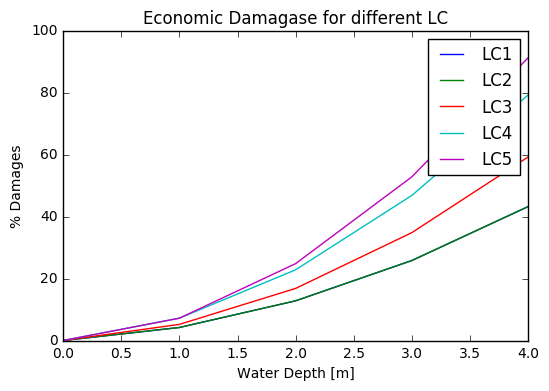

In [27]:
x =numpy.arange(5)
y=2.2*x*x+2*x
y1=2.2*x*x+2*x
y2=3.2*x*x+2*x
y3=4.2*x*x+3*x
y4=5.2*x*x+2*x

plt.xlabel('Water Depth [m]') # label
plt.ylabel('% Damages')
plt.title('Economic Damagase for different LC')
plt.plot(x, y, label='LC1')
plt.plot(x, y1, label='LC2')
plt.plot(x, y2, label='LC3')
plt.plot(x, y3, label='LC4')
plt.plot(x, y4, label='LC5')
plt.legend()

<img src="figures/ecodam.PNG">

In [5]:
def economiclosses(workdir,waterdepthfilename,Assetfilename,CORINEfilename,CorineClass):
    (ASSETVALUEgrid,geotransform,projection,nodata)=GDAL2Numpy(workdir+'output/'+'ASSET_'+CORINEfilename)
    ASSETVALUEgrid=numpy.where(ASSETVALUEgrid>0, ASSETVALUEgrid,0)
    DAMFRAC_map_tot=numpy.zeros((500,500),dtype=numpy.float)
    ECODAMAGE_map_tot=numpy.zeros((500,500),dtype=numpy.float)
    #print ECODAMAGE_map_tot
    for k in CorineClass:
        
        (WDgrid,geotransform,projection,nodata)=GDAL2Numpy(workdir+waterdepthfilename) #read water depth filename      
        (CORINEgrid,geotransform,projection,nodata)=GDAL2Numpy(workdir+CORINEfilename)
        if k>0 and k<=5:
            function='((2.2*X*X)+2*X)/100.0'
        if k>5 and k<=10:
            function='((3.2*X*X)+2*X)/100.0'
        if k>10 and k<=15:
            function='((4.2*X*X)+3*X)/100.0'
        if k>15 and k<=25:
            function='((5.2*X*X)+2*X)/100.0'
        if k>25:
            function='((6.2*X*X)+4*X)/100.0'        
        
        DAMFRAC_map=numpy.where(CORINEgrid==float(k),eval(function,{'X':WDgrid}),0.0)
    
        #print DAMFRAC_map
        #DAMFRAC_map=0.0012*numpy.power(WDgrid,3)+0.0257*numpy.power(WDgrid,2)+0.00113*WDgrid 
    
    
        DAMFRAC_map=numpy.where(DAMFRAC_map>0, DAMFRAC_map,0)
        DAMFRAC_map=numpy.where(DAMFRAC_map>1, 1,DAMFRAC_map)
        #Numpy2GTiff(DAMFRAC_map ,geotransform,projection,workdir+'DAMFRAC_'+waterdepthfilename)
        #(ASSETVALUEgrid,geotransform,projection,nodata)=GDAL2Numpy(workdir+'ASSET_'+CORINEfilename)
        #print LOL_map
        #ASSETVALUEgrid=numpy.where(ASSETVALUEgrid>0, ASSETVALUEgrid,0) 
        ECODAMAGE_map=DAMFRAC_map*(ASSETVALUEgrid)
        ECODAMAGE_map=numpy.where(ECODAMAGE_map>=1, ECODAMAGE_map,0)
        #print str(numpy.sum(ECODAMAGE_map))
        #print NunberOfDeathMap
        #print "Total Economic Damage kEURO="+str(numpy.sum(ECODAMAGE_map))
        #Numpy2GTiff(ECODAMAGE ,geotransform,projection,workdir+'ECODAM_'+waterdepthfilename)
        
        DAMFRAC_map_tot=DAMFRAC_map_tot+DAMFRAC_map
        ECODAMAGE_map_tot=ECODAMAGE_map_tot+ECODAMAGE_map
    Numpy2GTiff(DAMFRAC_map_tot ,geotransform,projection,workdir+'output/'+'DAMFRAC_'+waterdepthfilename)
    Numpy2GTiff(ECODAMAGE_map_tot ,geotransform,projection,workdir+'output/'+'ECODAM_'+waterdepthfilename)
    print "Total Economic Damage kEURO="+str(numpy.sum(ECODAMAGE_map_tot))
    return 'ECODAM_'+waterdepthfilename

In [6]:
numpy.seterr(all='ignore')
workdir='data/Chap_7/'

waterdepthfilename='floodMapEU_rp500y_Turim.tif'
Assetfilename='ASSET_'+CORINEfilename
CORINEfilename='g100_clc12_V18_5_Turim.tif'
CorineClass=uniquevalues.tolist()
print uniquevalues

economiclosses(workdir,waterdepthfilename,Assetfilename,CORINEfilename,CorineClass)

[  1.   2.   3.   4.   6.   7.   8.   9.  10.  11.  12.  14.  15.  16.  18.
  20.  21.  23.  24.  25.  26.  29.  30.  32.  40.  41.]
Total Economic Damage kEURO=46844131.0844


'ECODAM_floodMapEU_rp500y_Turim.tif'

### 7.1.3 Produce Damage Maps for each Flood Scenario

In [8]:
FloodscenarioRT=(10,20,50,100,200,500)
workdir='data/Chap_7/'
waterdepthfilename='floodMapEU_rp500y_Turim.tif'
Expopfilename='popu01clcv5_Turim.tif'
CORINEfilename='g100_clc12_V18_5_Turim.tif'
Assetfilename='ASSET_'+CORINEfilename
CorineClass=uniquevalues.tolist()
ecodamagelist=[]
lifedamagelist=[]
for RT in FloodscenarioRT:
    print "Scenario Return Time ="+str(RT)
    lifedamagelist.append(lifelosses(workdir,'floodMapEU_rp'+str(RT)+'y_Turim.tif',Expopfilename))
    ecodamagelist.append(economiclosses(workdir,'floodMapEU_rp'+str(RT)+'y_Turim.tif',Assetfilename,CORINEfilename,CorineClass))
print ecodamagelist
print lifedamagelist

Scenario Return Time =10
Total Number of Deaths=5774.27
Total Economic Damage kEURO=21847432.026
Scenario Return Time =20
Total Number of Deaths=7506.23
Total Economic Damage kEURO=26936914.6009
Scenario Return Time =50
Total Number of Deaths=10058.2
Total Economic Damage kEURO=33097295.7059
Scenario Return Time =100
Total Number of Deaths=12257.8
Total Economic Damage kEURO=37503325.5364
Scenario Return Time =200
Total Number of Deaths=14431.2
Total Economic Damage kEURO=41653400.4074
Scenario Return Time =500
Total Number of Deaths=17240.8
Total Economic Damage kEURO=46844131.0844
['ECODAM_floodMapEU_rp10y_Turim.tif', 'ECODAM_floodMapEU_rp20y_Turim.tif', 'ECODAM_floodMapEU_rp50y_Turim.tif', 'ECODAM_floodMapEU_rp100y_Turim.tif', 'ECODAM_floodMapEU_rp200y_Turim.tif', 'ECODAM_floodMapEU_rp500y_Turim.tif']
['NOD_floodMapEU_rp10y_Turim.tif', 'NOD_floodMapEU_rp20y_Turim.tif', 'NOD_floodMapEU_rp50y_Turim.tif', 'NOD_floodMapEU_rp100y_Turim.tif', 'NOD_floodMapEU_rp200y_Turim.tif', 'NOD_floodM

## 7.3 Combing Damage and Probability - Risk Map
**RISK = Damage Map (euro, deaths) * probability (1/year)**

Flood risk is frequently expressed as the expectation of the damage, i.e. the Expected Annual Damage (EAD)


<img src="figures/risk_5.PNG">
<img src="figures/risk_6.PNG">

In [9]:
workdir='data/Chap_7/'
FloodscenarioRT=(10,20,50,100,200,500)

RI_NOD_map_tot=numpy.zeros((500,500),dtype=numpy.float)
RI_ECO_map_tot=numpy.zeros((500,500),dtype=numpy.float)
for i in range (0, int(len(FloodscenarioRT))-1):
    Pj=FloodscenarioRT[i]
    Pj1=FloodscenarioRT[i+1]
    deltaP=float(Pj1-Pj)
    (ECOgrid_j,geotransform,projection,nodata)=GDAL2Numpy(workdir+'output/'+'ECODAM_floodMapEU_rp'+str(Pj)+'y_Turim.tif')
    (ECOgrid_j1,geotransform,projection,nodata)=GDAL2Numpy(workdir+'output/'+'ECODAM_floodMapEU_rp'+str(Pj1)+'y_Turim.tif')
    (NODgrid_j,geotransform,projection,nodata)=GDAL2Numpy(workdir+'output/'+'NOD_floodMapEU_rp'+str(Pj)+'y_Turim.tif')
    (NODgrid_j1,geotransform,projection,nodata)=GDAL2Numpy(workdir+'output/'+'NOD_floodMapEU_rp'+str(Pj1)+'y_Turim.tif')
    A_ECOgrid=0.5*(ECOgrid_j+ECOgrid_j1)
    A_NODgrid=0.5*(NODgrid_j+NODgrid_j1)
    RIj_ECO=(A_ECOgrid/deltaP)
    RIj_NOD=(A_NODgrid/deltaP)
    RI_NOD_map_tot=RI_NOD_map_tot+RIj_NOD
    RI_ECO_map_tot=RI_ECO_map_tot+RIj_ECO
Numpy2GTiff(RI_ECO_map_tot,geotransform,projection,workdir+'output/'+"TOTECORISK.tif")
Numpy2GTiff(RI_NOD_map_tot,geotransform,projection,workdir+'output/'+"TOTPOPRISK.tif")
    



'data/Chap_7/output/TOTPOPRISK.tif'

## 7.4  GIS-based Multi-Criteria Risk Mapping

For  natural  hazards,  risk-based  decision-making  is  a  multidimensional  and  multidisciplinary  activity  embracing  environmental,  socio-economic  and  management_related  factors  at  different spatial and temporal scales.  

Risk assessment is conducted in order to identify the magnitude and spatial distribution of flood risks. 
Most current approaches focus only on economic risks. 
Environmental, social and cultural risks are often neglected or mentioned as a side product. 

Multicriteria Analysis enables consideration of all relevant risks, is an appropriate method of incorporating all relevant types of consequences without measuring them on one monetary scale. 


**Multi-criteria Analysis (MCA) allows a comparison between different alternatives by a broader set of criteria which can all be expressed in their own different dimensions, be it qualitative or merely ranked (-- to + +).**


<img align="left" style="padding-right:10px;" src="figures/MCA_1.png">


<img align="left" style="padding-right:10px;" src="figures/MCA.png">

In [10]:
def interval_normalization(array):
    min=numpy.min(array)
    max=numpy.max(array)

    normalized = (array-min)/(max-min)
    return normalized

def max_normalization(array):

    max=numpy.max(array)

    normalized = (array/max)
    return normalized


def rasterMCA(ECORiskfilename,POPRiskfilename,normtype,w_eco,w_pop):
    
    (ECORisk,geotransform,projection,nodata)=GDAL2Numpy(workdir+'output/'+ECORiskfilename)
    (POPRisk,geotransform,projection,nodata)=GDAL2Numpy(workdir+'output/'+POPRiskfilename)

    #normalization
    if normtype=='interval':
    
        ECORisk=interval_normalization(ECORisk)
        POPRisk=interval_normalization(POPRisk)
    if normtype=='max':
    
        ECORisk=max_normalization(ECORisk)
        POPRisk=max_normalization(POPRisk)
    #weighting sum

    TOTRISK=w_eco*ECORisk+w_pop*POPRisk
    Numpy2GTiff(TOTRISK ,geotransform,projection,workdir+'output/'+'TOTRISK.tif')

In [11]:
ECORiskfilename="TOTECORISK.tif"
POPRiskfilename="TOTPOPRISK.tif"
normtype='max'
w_eco=0.4
w_pop=0.6
rasterMCA(ECORiskfilename,POPRiskfilename,normtype,w_eco,w_pop)

## 7.5 Exsercise

- Mapping the Economic Flood Risk for Bologna area.
 -Describe your code and results in a Jupyter notebook
 -Upload the notebook in GitHub and share it with nbviewer


### 7.5.1 Input Data
- floods maps
- corine land cover

### 7.5.2 Pseudo-Code

- Read Corine Land-Cover Map
- Assign Asset value for each corine class
- Read the flood map scenarios
- evaluate economic damages for each RT flood maps
- Compute the total risk
- Identify and map the areas under major flood risk



<!--NAVIGATION-->
< [7_Risk_Mapping Python_GDA](7_Risk_Mapping Python_GDAL.ipynb) | [Contents](Index.ipynb)  >